# <b>CS156 (Introduction to AI), Spring 2022</b>
# <u><b>Final Term Project</b></u>

### Roster Name: Austin Rivard
### Preferred Name (if different):
### Student ID: 015044445
### Email address: austin.rivard@sjsu.edu

##  <u> Project description/introduction text (the background information) </u>

This project was created with the goal of generating new images of doodles from seven different classes: airplane, ant, axe, bear, bicycle, bird, and bread.

Doodles are a very interesting domain of images to work with in computer vision because they are the human brain's attempt to represent an actual object (airplane, bicycle, bread) to other humans using very few features. When tasked with quickly drawing a doodle of an object from memory, a person is forced to think about the most efficient way to convey meaning that another person would likely understand. For this reason, doodles typically include the most distinguishing features of an object and could be a sort of window into how the human brain represents real-life objects internally.

Intrigued by this idea, I wanted to investigate how a machine learning model could learn to doodle. I chose these categories because they are so different from one another that the model would need to learn to draw a wide variety of objects as opposed to if I were to, say, choose just cats and dogs, although that could be an interesting dataset to to use to see the distinguishing features that it learns from each.

##  <u> Machine learning algorithm selected for this project </u>

The model used is a conditional deep convolutional GAN, or cDCGAN, with some additional modifications like spectral normalization added to help convergence of the model and improve the final quality of generated images. It took me many iterations to find hyperparameters that wouldn't result in the network falling into a failure mode during training. The most common failure mode was characterized by discriminator loss going to zero and generator loss climbing to around ten shortly after training began. I performed many experiments by tweaking the learning rate, ADAM momentum, latent space dimensionality, batch size, and also added spectral normalization to both the generator and discriminator and added dropout to just the generator. The hyperparameters used below are what I found success with through experimentation, but there are likely many changes that could be made to speed up training, improve image quality, or both.

##  <u> Dataset source </u>

### Quick, Draw! - Google

https://quickdraw.withgoogle.com/data

https://github.com/googlecreativelab/quickdraw-dataset

##  <u>References and sources </u>

Code examples used from:

Class reference notebook GAN.MNIST.ipynb for Dr. Yulia Newton's CS156 class

https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

https://github.com/soumith/ganhacks

https://arxiv.org/abs/1611.07004

https://arxiv.org/abs/1809.11096

https://arxiv.org/abs/1807.04720

https://arxiv.org/abs/1802.05957

##  <u>Solution</u>

#### Load libraries and set random number generator seed

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

In [2]:
np.random.seed(42)

In [3]:
from tensorflow.python.keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

#### Code the solution

In [4]:
ls data

 Volume in drive C is Windows
 Volume Serial Number is 9CA3-5D2E

 Directory of c:\Users\itsau\Code\School\CS156\Term Project\data

05/13/2022  06:46 PM    <DIR>          .
05/14/2022  07:52 PM    <DIR>          ..
05/13/2022  06:44 PM       118,872,512 full_numpy_bitmap_airplane.npy
05/13/2022  06:44 PM        97,695,888 full_numpy_bitmap_ant.npy
05/13/2022  06:44 PM        97,311,728 full_numpy_bitmap_axe.npy
05/13/2022  06:44 PM       105,653,488 full_numpy_bitmap_bear.npy
05/13/2022  06:45 PM        99,197,248 full_numpy_bitmap_bicycle.npy
05/13/2022  06:45 PM       104,720,528 full_numpy_bitmap_bird.npy
05/13/2022  06:45 PM        94,526,960 full_numpy_bitmap_bread.npy
               7 File(s)    717,978,352 bytes
               2 Dir(s)  533,265,866,752 bytes free


In [5]:
LR = 0.0002
beta_1 = 0.5
beta_2 = 0.999

def define_discriminator(in_shape=(28,28,1), n_classes=7):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = tfa.layers.SpectralNormalization(Conv2D(128, (3,3), strides=(2,2), padding='same'))(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=LR, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=7):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = Dropout(0.5)(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = tfa.layers.SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=LR, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

import os
label_map = {
    'airplane': 0,
    'ant': 1,
    'axe': 2,
    'bear': 3,
    'bicycle': 4,
    'bird': 5,
    'bread': 6
}
def load_real_samples(dir='data'):
    X, Y = [], []
    for filename in os.listdir(dir):
        label = filename.split('_')[-1].split('.')[0]
        data = np.load(dir + '/' + filename)
        data = data.reshape(data.shape[0], 28, 28, 1)
        y = np.full(data.shape[0], label_map[label])
        X.append(data)
        Y.append(y)
    X = np.concatenate(X, axis=0)
    # X = np.expand_dims(X, axis=-1)
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    Y = np.concatenate(Y, axis=0)
    # synchronously shuffle X and Y
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    X = X[randomize]
    Y = Y[randomize]
    return [X, Y]

# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = np.random.randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = np.ones((n_samples, 1))
	return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=7):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=70):
	# prepare fake examples
	latent_points, labels = generate_latent_points(latent_dim, n_samples)
	# specify labels
	labels = np.asarray([x for _ in range(10) for x in range(7)])
	# generate images
	X  = g_model.predict([latent_points, labels])
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(7 * 10):
		# define subplot
		plt.subplot(10, 7, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	plt.savefig('results_baseline/generated_plot_%03d.png' % (step+1))
	plt.close()
	# save the generator model
	g_model.save('results_baseline/model_%03d.h5' % (step+1))

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
	# plot loss
	plt.subplot(2, 1, 1)
	plt.plot(d1_hist, label='d-real')
	plt.plot(d2_hist, label='d-fake')
	plt.plot(g_hist, label='gen')
	plt.legend()
	# plot discriminator accuracy
	plt.subplot(2, 1, 2)
	plt.plot(a1_hist, label='acc-real')
	plt.plot(a2_hist, label='acc-fake')
	plt.legend()
	# save plot to file
	plt.savefig('results_baseline/plot_line_plot_loss.png')
	plt.close()

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, d_acc1 = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, d_acc2 = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f, a1=%d, a2=%d' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2)))
					# record history
			d1_hist.append(d_loss1)
			d2_hist.append(d_loss2)
			g_hist.append(g_loss)
			a1_hist.append(d_acc1)
			a2_hist.append(d_acc2)
		# evaluate the model performance every epoch
		summarize_performance(i, g_model, latent_dim)
	plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)
	# save the generator model
	g_model.save('cgan_generator.h5')

In [6]:
# size of the latent space
latent_dim = 128
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

c:\Users\itsau\anaconda3\envs\tf_gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [7]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=2048)

>1, 1/447, d1=0.709, d2=0.695, g=0.691, a1=36, a2=1
>1, 2/447, d1=0.615, d2=0.701, g=0.685, a1=98, a2=0
>1, 3/447, d1=0.542, d2=0.710, g=0.674, a1=100, a2=0
>1, 4/447, d1=0.477, d2=0.729, g=0.656, a1=100, a2=0
>1, 5/447, d1=0.419, d2=0.759, g=0.629, a1=100, a2=0
>1, 6/447, d1=0.366, d2=0.805, g=0.594, a1=100, a2=0
>1, 7/447, d1=0.323, d2=0.865, g=0.558, a1=100, a2=0
>1, 8/447, d1=0.303, d2=0.923, g=0.534, a1=100, a2=0
>1, 9/447, d1=0.298, d2=0.954, g=0.534, a1=100, a2=0
>1, 10/447, d1=0.309, d2=0.936, g=0.570, a1=100, a2=0
>1, 11/447, d1=0.330, d2=0.862, g=0.634, a1=100, a2=0
>1, 12/447, d1=0.360, d2=0.778, g=0.721, a1=100, a2=4
>1, 13/447, d1=0.388, d2=0.681, g=0.812, a1=99, a2=60
>1, 14/447, d1=0.408, d2=0.600, g=0.905, a1=99, a2=96
>1, 15/447, d1=0.429, d2=0.540, g=0.963, a1=98, a2=100
>1, 16/447, d1=0.450, d2=0.514, g=0.981, a1=96, a2=100
>1, 17/447, d1=0.467, d2=0.505, g=1.002, a1=95, a2=100
>1, 18/447, d1=0.469, d2=0.503, g=0.999, a1=94, a2=100
>1, 19/447, d1=0.451, d2=0.533, g=0

In [11]:
# train model a second time
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=2048)

>1, 1/447, d1=0.472, d2=0.490, g=1.437, a1=80, a2=84
>1, 2/447, d1=0.500, d2=0.530, g=1.406, a1=77, a2=80
>1, 3/447, d1=0.535, d2=0.556, g=1.415, a1=74, a2=76
>1, 4/447, d1=0.550, d2=0.475, g=1.526, a1=72, a2=86
>1, 5/447, d1=0.564, d2=0.423, g=1.566, a1=71, a2=92
>1, 6/447, d1=0.520, d2=0.453, g=1.481, a1=77, a2=89
>1, 7/447, d1=0.491, d2=0.468, g=1.383, a1=79, a2=88
>1, 8/447, d1=0.524, d2=0.513, g=1.293, a1=74, a2=80
>1, 9/447, d1=0.497, d2=0.545, g=1.334, a1=77, a2=78
>1, 10/447, d1=0.493, d2=0.495, g=1.431, a1=77, a2=83
>1, 11/447, d1=0.486, d2=0.471, g=1.421, a1=79, a2=87
>1, 12/447, d1=0.477, d2=0.493, g=1.404, a1=81, a2=82
>1, 13/447, d1=0.473, d2=0.517, g=1.382, a1=80, a2=81
>1, 14/447, d1=0.525, d2=0.509, g=1.388, a1=75, a2=85
>1, 15/447, d1=0.543, d2=0.489, g=1.448, a1=72, a2=86
>1, 16/447, d1=0.560, d2=0.460, g=1.423, a1=70, a2=90
>1, 17/447, d1=0.532, d2=0.461, g=1.403, a1=76, a2=90
>1, 18/447, d1=0.497, d2=0.472, g=1.378, a1=79, a2=85
>1, 19/447, d1=0.530, d2=0.510, g=1.3

In [8]:
(imgs, lbls), _ = generate_real_samples(dataset, 9)

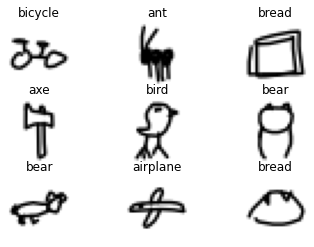

In [13]:
num_to_label = {v: k for k, v in label_map.items()}

# create and display a plot of generated images (reversed grayscale)
def display_plot(examples, labels, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.title(num_to_label[labels[i]])
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

display_plot(imgs, lbls, 3)

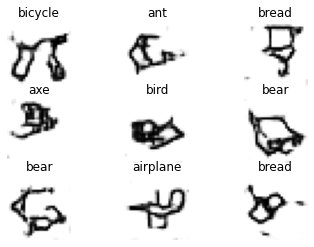

In [16]:
latent_points, _ = generate_latent_points(latent_dim, 9)
generated_imgs = g_model.predict([latent_points, lbls])
display_plot(generated_imgs, lbls, 3)

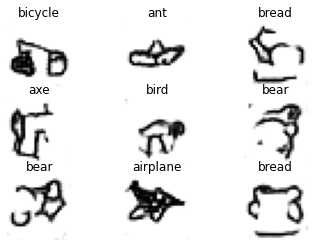

In [19]:
latent_points, _ = generate_latent_points(latent_dim, 9)
generated_imgs = g_model.predict([latent_points, lbls])
display_plot(generated_imgs, lbls, 3)